<a href="https://colab.research.google.com/github/Thandriss/DL_labs/blob/main/LMU_SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
!git clone --recurse-submodules https://github.com/Patrick-Schubert/tensorflow2_LMU.git lmu
!pip install nengolib
!pip install tensorflow-addons
import lmu.keras_lmu
import tensorflow as tf
from tensorflow_addons.optimizers import RectifiedAdam
from keras.layers.recurrent import RNN
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten, Input, ELU, ReLU, Concatenate, RepeatVector
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

fatal: destination path 'lmu' already exists and is not an empty directory.


In [34]:
data_path = '/content/kaggle/train.csv'
data = pd.read_csv(data_path)
data = data[['user_review', 'user_suggestion']]
data.head()

,user_review,user_suggestion
0,I'm scared and hearing creepy voices. So I'll...,1
1,"Best game, more better than Sam Pepper's YouTu...",1
2,"A littly iffy on the controls, but once you kn...",1
3,"Great game, fun and colorful and all that.A si...",1
4,Not many games have the cute tag right next to...,1


In [35]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    #text = text.replace('\%','')
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    #text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = " ".join(filter(lambda x:x[0]!="@", text.split()))
    return text

#Apply the function
data['user_review'] = data['user_review'].apply(lambda x: clean_text(x))

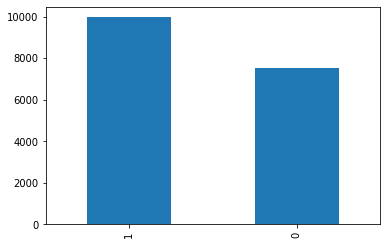

In [36]:
data['user_suggestion'].value_counts().plot(kind='bar')

In [37]:
print(data[ data['user_suggestion'] == 1].size)
print(data[ data['user_suggestion'] == 0].size)

max_length = 2

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['user_review'].values)
X = tokenizer.texts_to_sequences(data['user_review'].values)
X = pad_sequences(X, maxlen=max_length, truncating='pre', padding='pre')

19936
15052


In [38]:
Y = pd.get_dummies(data['user_suggestion']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(11720, 2) (11720, 2)
(5774, 2) (5774, 2)


In [43]:

batch_size = 1024*4

n_pixels = X_train.shape[1]

lmu_layer = lmu.keras_lmu.LMU(
    memory_d=1,
    order=256,
    theta=n_pixels,
    hidden_cell=tf.keras.layers.SimpleRNNCell(212),
    hidden_to_memory=False,
    memory_to_memory=False,
    input_to_hidden=True,
    kernel_initializer="ones",
)

# TensorFlow layer definition
inputs = tf.keras.Input((n_pixels, 1))
lmus = lmu_layer(inputs)
outputs = tf.keras.layers.Dense(2)(lmus)

# TensorFlow model definition
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=["accuracy"],
)

print(model.summary())
print(X.shape[1])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 2, 1)]            0         
                                                                 
 lmu_2 (LMU)                 (None, 212)               99641     
                                                                 
 dense_2 (Dense)             (None, 2)                 426       
                                                                 
Total params: 100,067
Trainable params: 100,067
Non-trainable params: 0
_________________________________________________________________
None
2


In [44]:
batch_size = 64
model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, verbose = 2)

Epoch 1/10
184/184 - 4s - loss: 3.3721 - accuracy: 0.5437 - 4s/epoch - 20ms/step
Epoch 2/10
184/184 - 2s - loss: 2.4099 - accuracy: 0.5470 - 2s/epoch - 13ms/step
Epoch 3/10
184/184 - 2s - loss: 2.9943 - accuracy: 0.5518 - 2s/epoch - 13ms/step
Epoch 4/10
184/184 - 2s - loss: 3.1292 - accuracy: 0.5594 - 2s/epoch - 13ms/step
Epoch 5/10
184/184 - 2s - loss: 2.9694 - accuracy: 0.5582 - 2s/epoch - 13ms/step
Epoch 6/10
184/184 - 2s - loss: 2.7668 - accuracy: 0.5416 - 2s/epoch - 13ms/step
Epoch 7/10
184/184 - 2s - loss: 7.6019 - accuracy: 0.4877 - 2s/epoch - 13ms/step
Epoch 8/10
184/184 - 2s - loss: 7.6460 - accuracy: 0.4891 - 2s/epoch - 13ms/step
Epoch 9/10
184/184 - 2s - loss: 7.4148 - accuracy: 0.4904 - 2s/epoch - 13ms/step
Epoch 10/10
184/184 - 2s - loss: 5.5160 - accuracy: 0.4922 - 2s/epoch - 13ms/step


In [45]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

67/67 - 1s - loss: 5.6346 - accuracy: 0.4780 - 737ms/epoch - 11ms/step
score: 5.63
acc: 0.48


In [46]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

1/1 - 0s - 212ms/epoch - 212ms/step
1/1 - 0s - 12ms/epoch - 12ms/step
1/1 - 0s - 12ms/epoch - 12ms/step
1/1 - 0s - 12ms/epoch - 12ms/step
1/1 - 0s - 12ms/epoch - 12ms/step
1/1 - 0s - 12ms/epoch - 12ms/step
1/1 - 0s - 12ms/epoch - 12ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 12ms/epoch - 12ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 12ms/epoch - 12ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 12ms/epoch - 12ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 12ms/epoch - 12ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 12ms/epoch - 12ms/step
1/1 - 0s - 1

In [47]:
twt = ['Meetings: Because none of us is as dumb as all of us.']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=2, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  8 395]]
1/1 - 0s - 14ms/epoch - 14ms/step
negative
